# Content <-> audience

In [87]:
import numpy as np
import pandas as pd
import warnings

from itertools import product
from tqdm import tqdm

from scipy import stats

In [88]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [89]:
warnings.simplefilter('ignore')

In [90]:
dfc = pd.read_json('data/hl-graph.json', lines=True)

In [91]:
dfa = pd.read_json('data/user-graph.json', lines=True)

In [92]:
DOMAINS = dfc.d1.unique()

In [93]:
C_METRICS = sorted(set(dfc.columns) - {'d1', 'd2'})

In [94]:
A_METRICS = sorted(set(dfa.columns) - {'d1', 'd2'})

In [95]:
def plot_domain_content(domain, title=None, dst=None):
    
    pdf = dfc[dfc.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], C_METRICS)
    
    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

In [96]:
def plot_domain_audience(domain, title=None, dst=None):
    
    pdf = dfa[dfa.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], A_METRICS)

    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')

    plt.show()

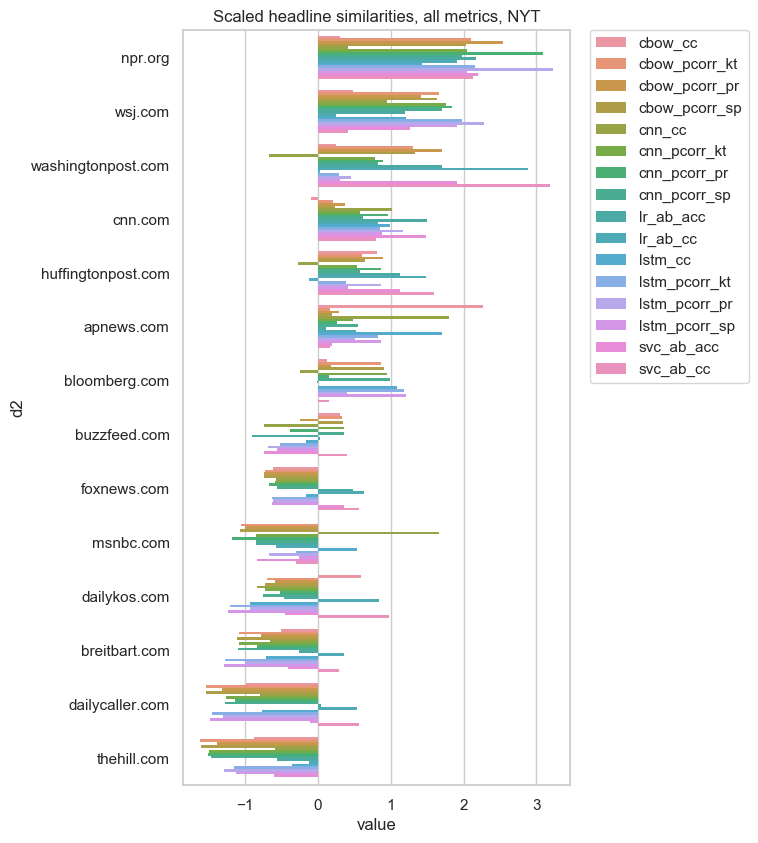

In [97]:
plot_domain_content('nytimes.com', 'Scaled headline similarities, all metrics, NYT', 'figures/ca-nyt-content.png')

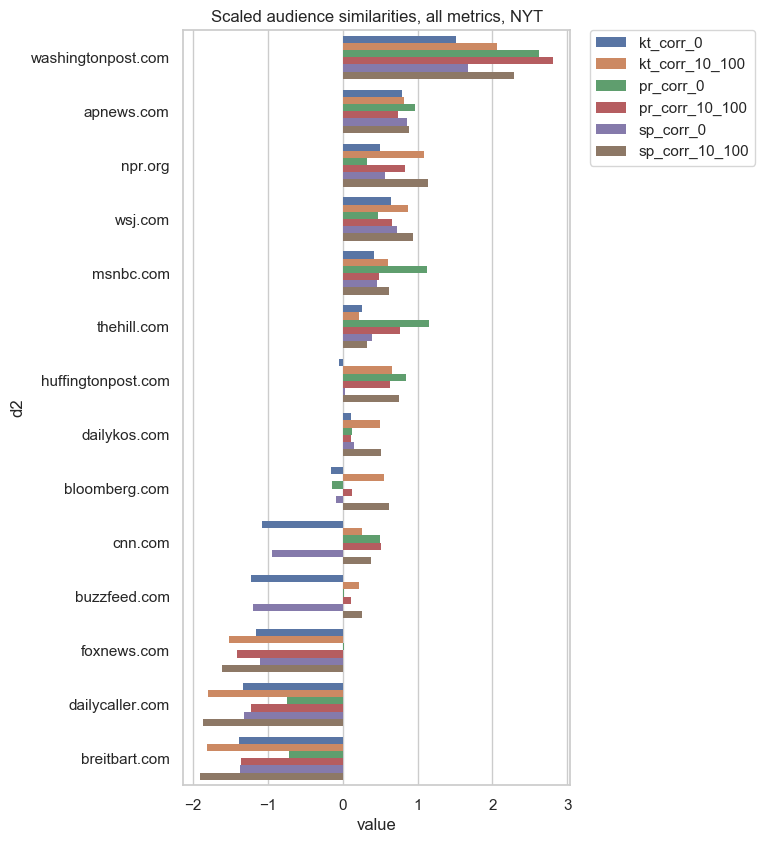

In [98]:
plot_domain_audience('nytimes.com', 'Scaled audience similarities, all metrics, NYT', 'figures/ca-nyt-audience.png')

In [99]:
def ca_corr(domain, c_metric, a_metric, plot=False):
    
    ddfc = dfc[dfc.d1==domain][['d2', c_metric]]
    ddfa = dfa[dfa.d1==domain][['d2', a_metric]]
    
    ddf = ddfc.merge(ddfa)
    
    if plot:
        ddf_melt = ddf.melt('d2', [c_metric, a_metric])
        order = ddf.sort_values(c_metric, ascending=False).d2
        plt.figure(figsize=(4,5))
        sns.barplot(y='d2', x='value', hue='variable', data=ddf_melt, order=order)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    return stats.kendalltau(ddf[c_metric], ddf[a_metric])

In [100]:
rows = []
for d, cm, am in tqdm(product(DOMAINS, C_METRICS, A_METRICS)):
    corr, p = ca_corr(d, cm, am)
    rows.append((d, cm, am, corr, p))

1440it [00:05, 246.00it/s]


In [101]:
corr_df = pd.DataFrame(rows, columns=('domain', 'cm', 'am', 'corr', 'p'))

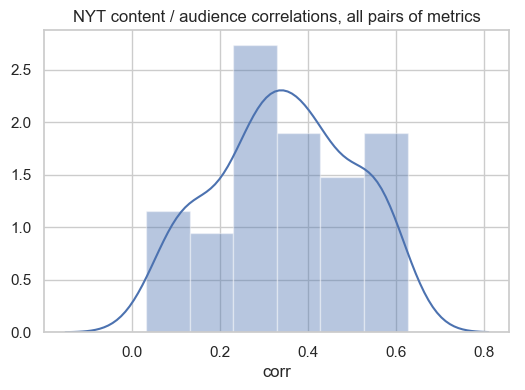

In [102]:
plt.figure(figsize=(6,4), dpi=100)
plt.title('NYT content / audience correlations, all pairs of metrics')
sns.distplot(corr_df[corr_df.domain=='nytimes.com']['corr'])
plt.savefig('figures/nyt-corr-dist.png', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

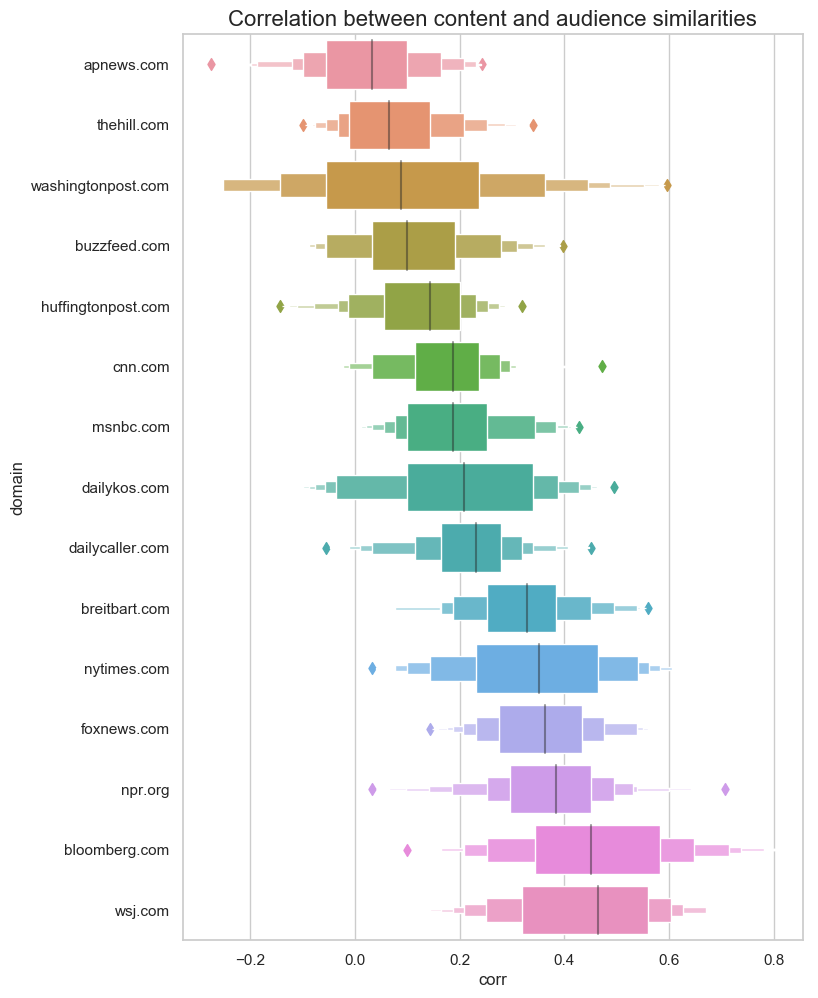

In [103]:
order = corr_df.groupby('domain').median().sort_values('corr').index
plt.figure(figsize=(8,12), dpi=100)
plt.title('Correlation between content and audience similarities', fontsize=16)
sns.boxenplot(x='corr', y='domain', data=corr_df, order=order)
plt.savefig('figures/ca-corr.png', bbox_inches='tight')

In [104]:
def plot_ac(domain, dst):
    
    ddfc = dfc[dfc.d1==domain]
    ddfa = dfa[dfa.d1==domain]
    ddf = ddfc.merge(ddfa)
    
    pdf = ddf.melt(['d2'], C_METRICS+A_METRICS)
    pdf['metric_type'] = pdf['variable'].apply(lambda x: 'content' if x in C_METRICS else 'audience')
    
    order = pdf[pdf.metric_type=='content'].groupby('d2').mean().sort_values('value', ascending=False).index
    
    plt.figure(figsize=(5,5), dpi=100)
    plt.title(domain)
    plt.xlim(-3, 3)
    sns.barplot(y='d2', x='value', hue='metric_type', data=pdf, order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

apnews.com


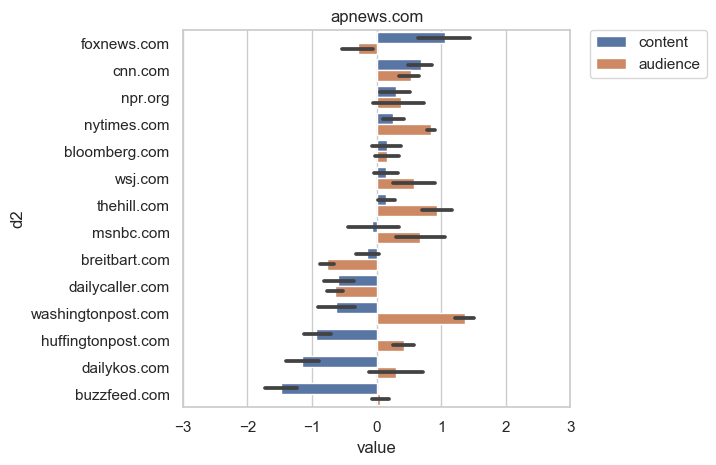

thehill.com


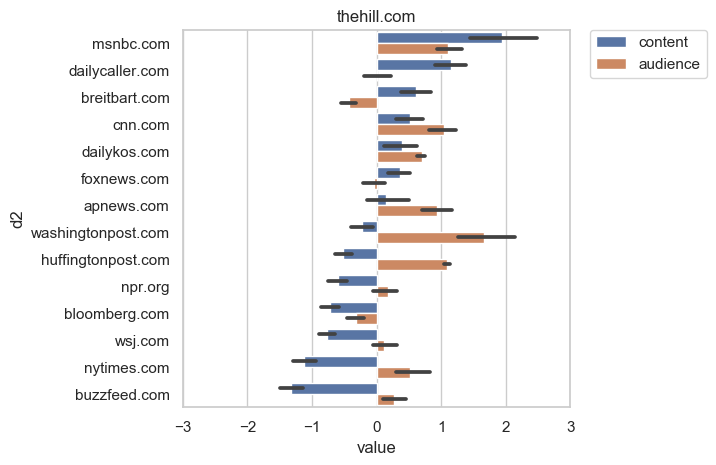

washingtonpost.com


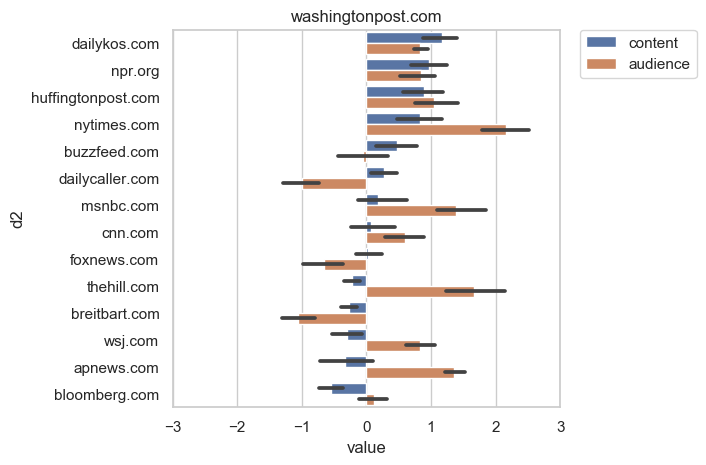

buzzfeed.com


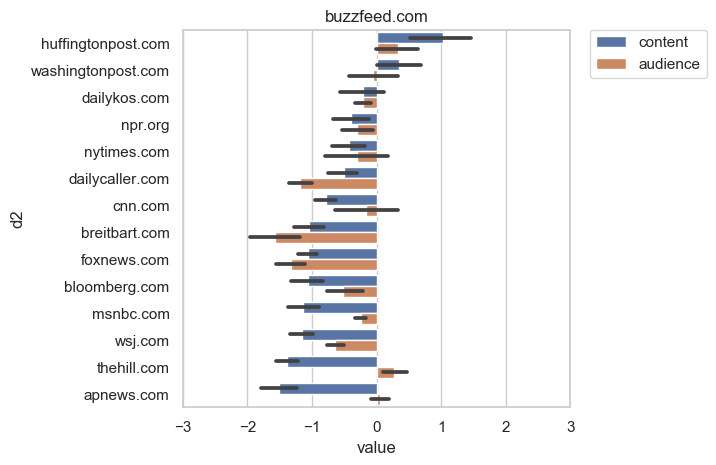

huffingtonpost.com


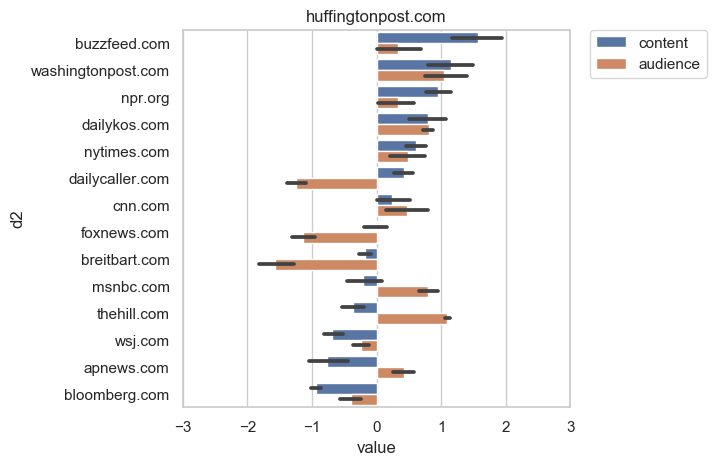

cnn.com


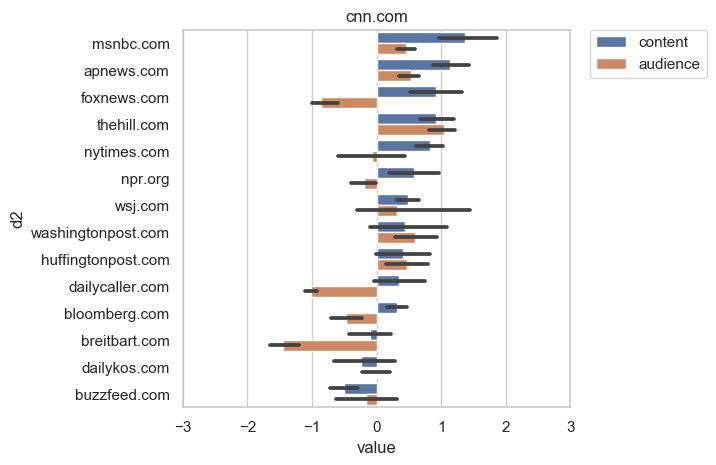

msnbc.com


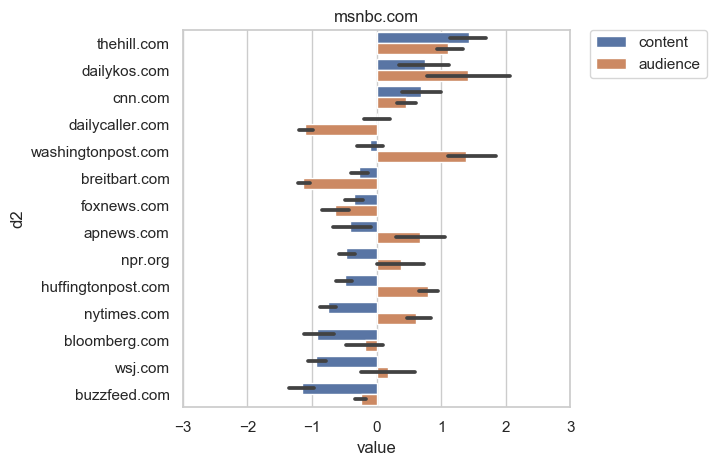

dailykos.com


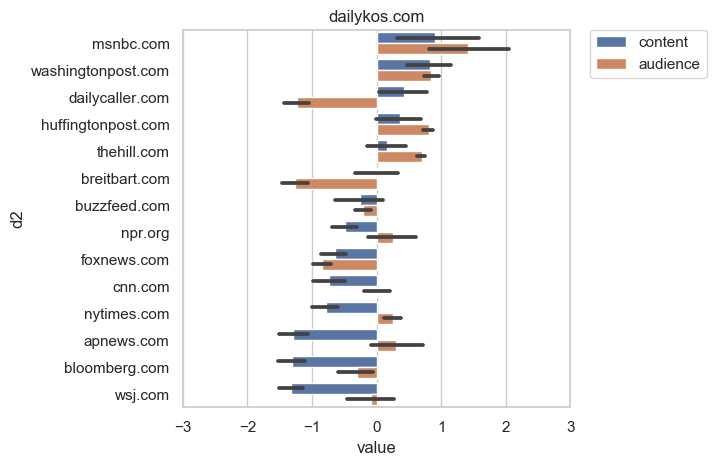

dailycaller.com


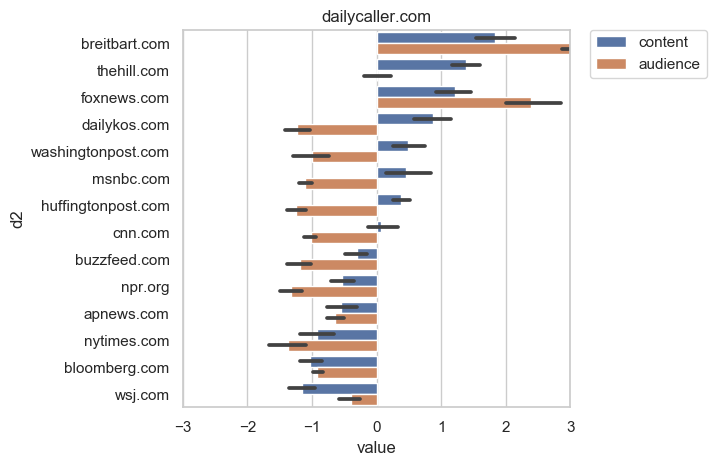

breitbart.com


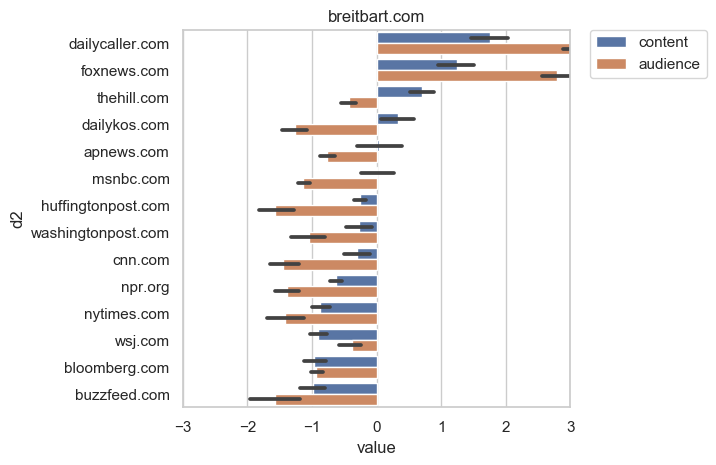

nytimes.com


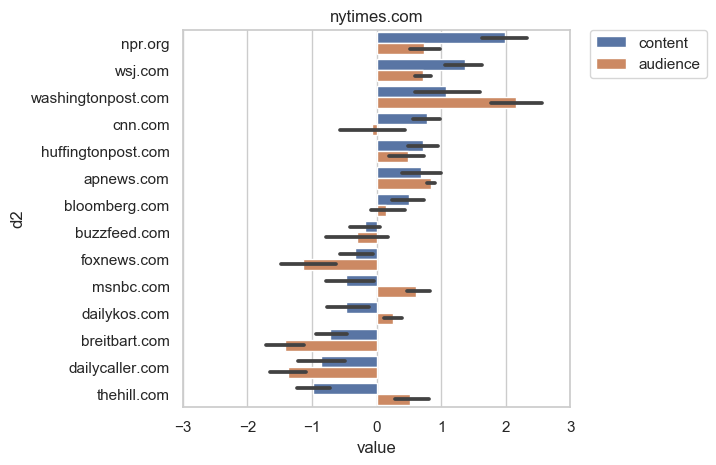

foxnews.com


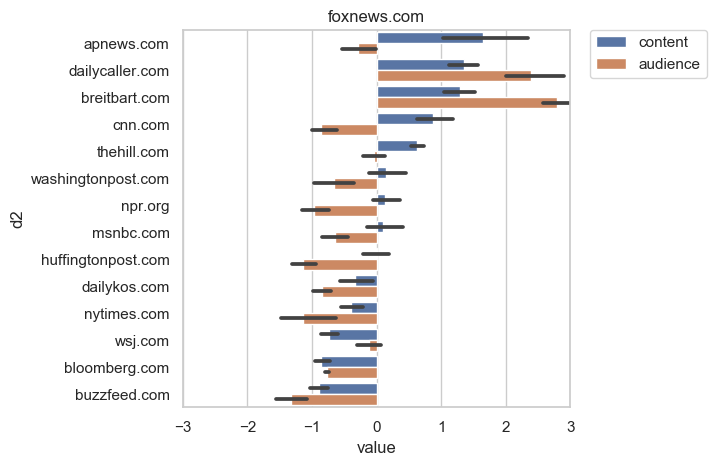

npr.org


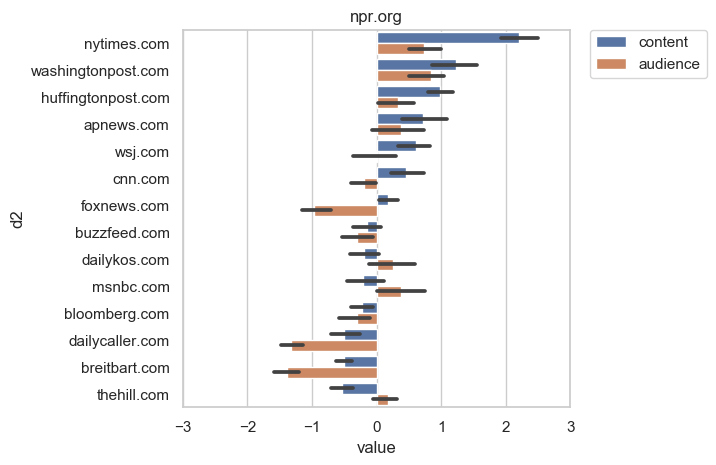

bloomberg.com


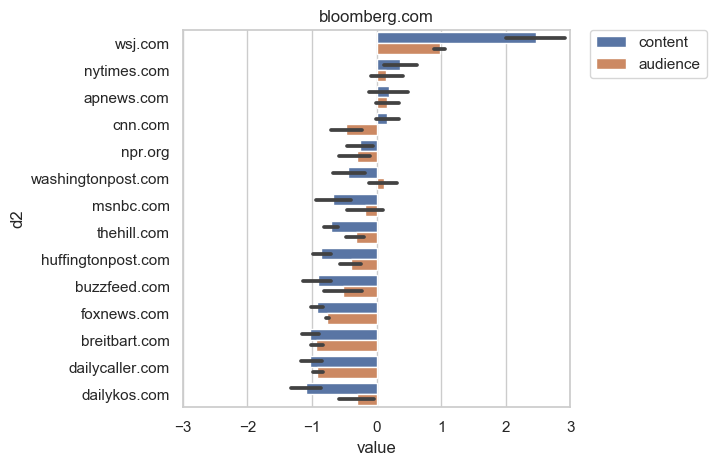

wsj.com


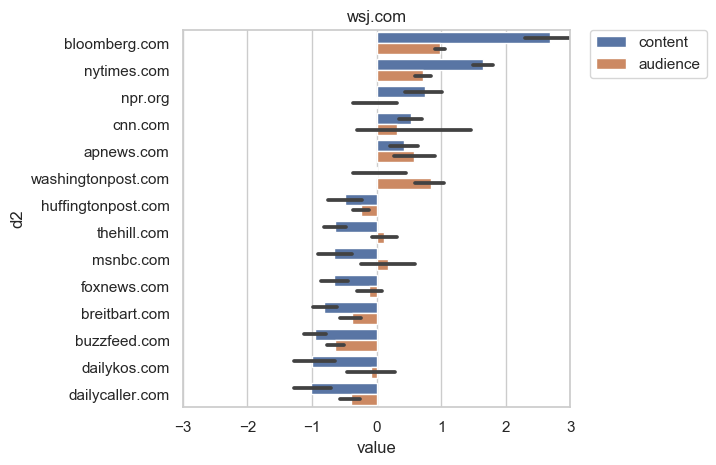

In [105]:
for d in order:
    print(d)
    slug = d.split('.')[0]
    plot_ac(d, f'figures/ca-{slug}-composite.')

- Bloomberg and WSJ with highest correlation; or, as they sound more and less like other outlets, they also have greater and lesser level of audience overlap. Probably not an accident that these are both financial / business outlets. One interp is that people have very functional / content-based relationship with these outlets around business news. Or, group of readers who are interested in financial news, but don't really care where it comes from, don't have strong media brand attachments. So, if NYT sounds like WSJ (business articles), then readership follows.

- "Misaligned" outlets follow different patterns.

- Extreme case is AP -- high HL overlap with Fox, but low audience overlap; high audience overlap with WaPo. So AP sounds like Fox, but gets read by WaPo audience. What's up here? Of course, one significant aspect of this is that AP is a wire service that produces articles that literally get syndicated by other outlets. Indeed, XX AP hls from AP in Fox. But not whole story, Fox also generates in-house content that looks like AP. Essentially -- crime reporting and international affairs.

- Even more extreme when centering on Fox -- most similar to AP in hls, but very low audience overlap, especially relative to BB/DC, where audience correlation is incredibly high.

- For Hill -- similar to capitol hill reporting from Breitbart / DC / MSNBC, but, again, highest audience overlap with WaPo. Driver here appears to be largely politico slang words like "dem" and "gop"; a kind of professional, inside-the-beltway lexicon for talking about politics.

- Two notes here -- first, interesting that for both AP and Hill, they serve as conduits that expose WaPo readers to headlines that are often more typical of right leaning outlets. But, the cause of the similarity are different. With (Fox, AP) -> WaPo, similarity is largely content (crime, foreign news); whereas with (BB, Hill) -> WaPo, similarity is largely style (dem, dems, gop).

- The Hill stands out, really, as the potential "bridge" outlet, if we bracket AP, to the extent that the syndication is an anomaly. In the other direction, looking at BB/DC - Hill is the one left-leaning outlet that's able to "crack" the audience wall with the far-right outlets.

In [79]:
df = dfc.merge(dfa)

In [80]:
df['c_mean'] = df.apply(lambda r: np.mean([r[col] for col in C_METRICS]), 1)

In [81]:
df['a_mean'] = df.apply(lambda r: np.mean([r[col] for col in A_METRICS]), 1)

In [82]:
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} -> {x[1]}', axis=1)

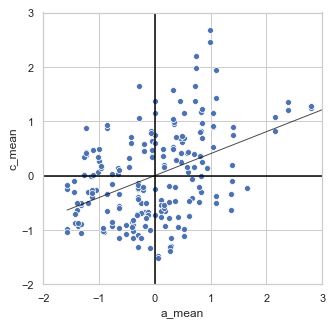

In [83]:
lr = stats.linregress(df.a_mean, df.c_mean)

fitx = np.array([df.a_mean.min(), df.a_mean.max()])
fity = lr.slope * fitx + lr.intercept

plt.figure(figsize=(5,5))
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.axhline(0, c='black')
plt.axvline(0, c='black')
ax = sns.scatterplot(x='a_mean', y='c_mean', data=df)
ax.plot(fitx, fity, c='black', linewidth=1, alpha=0.7)

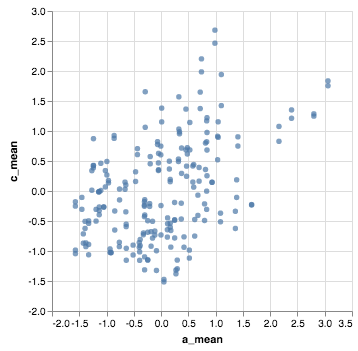

In [84]:
alt.Chart(df, width=300, height=300).mark_circle().encode(x='a_mean', y='c_mean', tooltip='label')

In [85]:
df['ca_delta'] = df.c_mean - df.a_mean

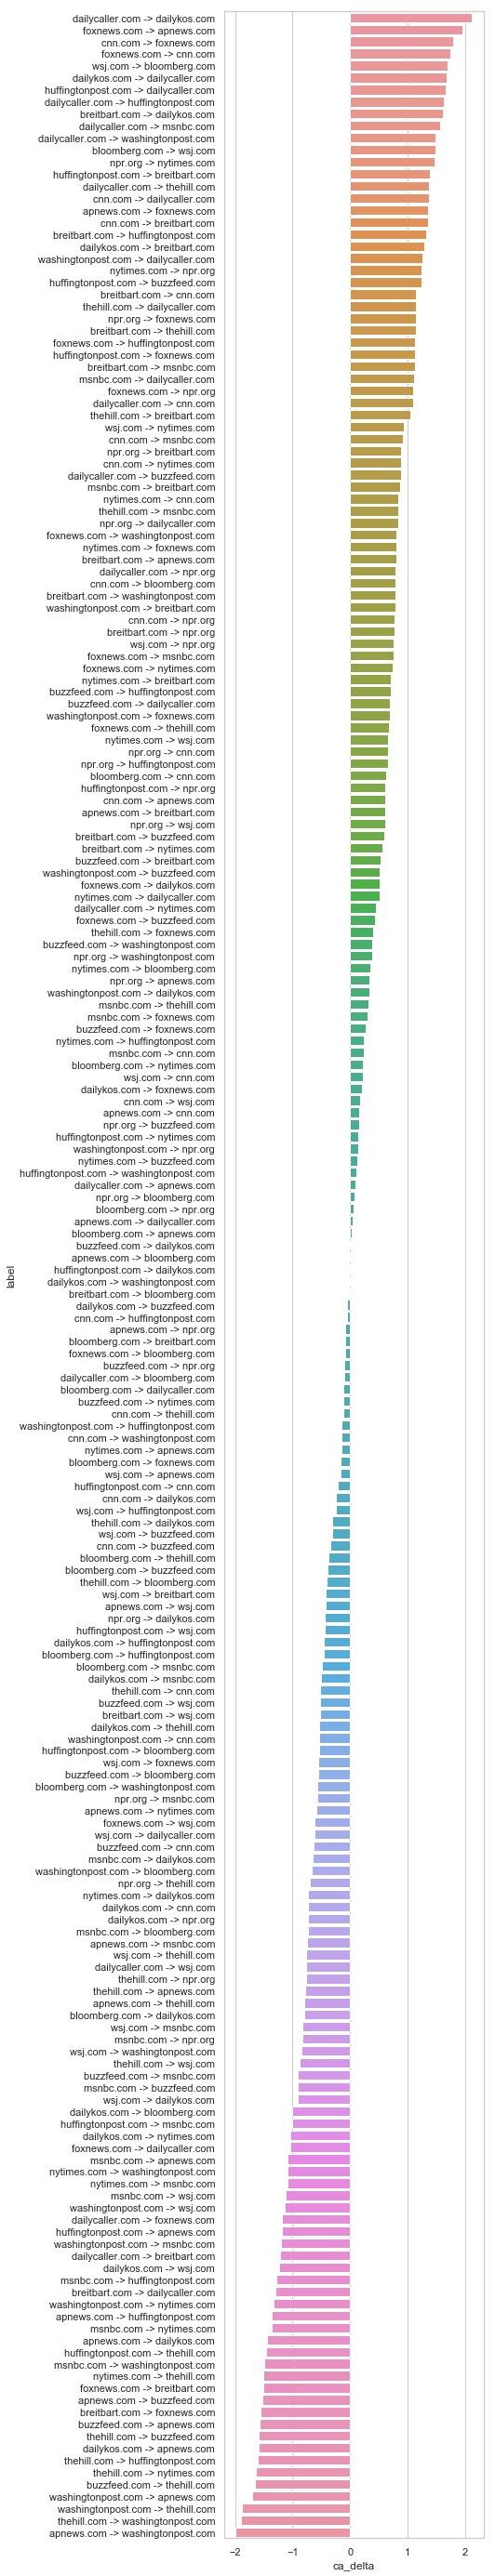

In [86]:
plt.figure(figsize=(5,50))
sns.barplot(x='ca_delta', y='label', data=df.sort_values('ca_delta', ascending=False))